In [1]:
import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.9'
import jax
import jax.numpy as jnp
import numpy as np
from jax import random, grad, vmap, jit, hessian
from jax.example_libraries import optimizers
from jax.experimental.ode import odeint
from jax.nn import relu, elu
# from jax.ops import index_update, index
from jax import lax
from jax.flatten_util import ravel_pytree

import itertools
from functools import partial
from torch.utils import data
from tqdm import trange, tqdm
import matplotlib.pyplot as plt
import time
import scipy.optimize as sp_opt



from scipy.interpolate import griddata
from scipy.sparse import csr_matrix
%matplotlib inline
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

cpu


In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0,1"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
import time
def timeit(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        execution_time = end_time - start_time
        print("Execution time: {:.2f} seconds".format(execution_time))
        return result, execution_time
    return wrapper

# dataset

In [4]:

def load_data_from_file(datafile="../../data/gauss/gauss_1d.npz"):
    data = np.load(datafile)
    all_data = data['all_data']
    means = data['means']
    stds = data['stds']
    Ns = data['Ns']
    
    return all_data, means, stds, Ns
all_data, means, stds, Ns = load_data_from_file()
m = len(Ns)


In [5]:
from sklearn.model_selection import train_test_split
n_samples, n_features = all_data.shape

# 假设all_data是二维的，而means, stds, Ns是一维的
# 例如:
# all_data.shape = (n_samples, n_features)
# means.shape = (n_samples,)
# stds.shape = (n_samples,)
# Ns.shape = (n_samples,)

# 将一维数组转换为二维数组
means_2d = means[:, np.newaxis]  # 现在形状是 (n_samples, 1)
stds_2d = stds[:, np.newaxis]    # 现在形状是 (n_samples, 1)
Ns_2d = Ns[:, np.newaxis]        # 现在形状是 (n_samples, 1)

# 现在所有的数组都是二维的，并且具有相同的行数
# 将它们堆叠起来以进行分割
data_arrays = np.hstack((all_data, means_2d, stds_2d, Ns_2d))

# 使用train_test_split打乱并分割数据
train_data, test_data = train_test_split(data_arrays, test_size=0.2, random_state=42)

# 分离出训练和测试数据
train_all_data = train_data[:, :n_features]  # 假设n_features是all_data的特征数量
train_means = train_data[:, n_features]
train_stds = train_data[:, n_features + 1]
train_Ns = train_data[:, n_features + 2]

test_all_data = test_data[:, :n_features]
test_means = test_data[:, n_features]
test_stds = test_data[:, n_features + 1]
test_Ns = test_data[:, n_features + 2]



In [6]:
## Example Generater: For illustration use, no involvement of embedding of physical parameters. 

class TrainingDataGenerator: 
    def __init__(self,opt,rng_key=random.PRNGKey(12)):
        'Initialization'
        # self.eta_list=opt.eta_list
        self.dim = opt.dim
        n_dict = opt.n_dict
        self.N = opt.N_data  # 100000 
        self.data_set=jnp.zeros([n_dict,self.N,self.dim+self.dim+opt.d_eta])
        #n_dict=len(eta_list)={i},N,[x1,y1,eta_list[i],x2,y2]
        self.key = rng_key
        
        for i_dict in range(n_dict):
            self.key, subkey = random.split(self.key)
            output_data,eta,j=self.gauss_train(i_dict)
            # eta=0
            # output_data=self.moon_Right(random.uniform(subkey,shape=[self.N,self.dim]))
            self.data_set=self.data_set.at[i_dict,:,0:self.dim].set(output_data)
            self.data_set=self.data_set.at[i_dict,:,self.dim:self.dim+self.dim].set(random.uniform(subkey,shape=[self.N,opt.dim]))
            self.data_set=self.data_set.at[i_dict,:,self.dim+self.dim:].set(eta)
            opt.eta_list.append(eta) 
            opt.index_list.append(j) #index of the image used to generate the data
            #2 is the index of physical parameter 
        self.batch_size = opt.batch_size

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        inputs, outputs= self.__data_generation(subkey)
        return inputs, outputs

    @partial(jit, static_argnums=(0,))
    def __data_generation(self, key):
        'Generates data containing batch_size samples'
        idx = random.choice(key, self.N, (self.batch_size,), replace=False)
        #0,1
        outputs = self.data_set[:,idx,0:self.dim]# 
        inputs = self.data_set[:,idx,self.dim:]#2+self.param_dim
        return inputs, outputs #y=f(x),f=mlp, batch_size samples of x,y
    
    def gauss_train(self,i_dict):
        # random.randint(key, 0, 1000000)
        j = i_dict#np.random.randint(m)
        # j = i_dict = np.random.randint(m)

        # 获取第j张图的数据,随机
        data = train_all_data[j, :]
        mean =train_means[j]
        std = train_stds[j]
        # N = Ns[j]
        eta = [mean,std]
        data =  np.expand_dims(data, axis=1)
        # print(eta)
        return data,eta,j

    def gauss_test(self,i_dict):
        # random.randint(key, 0, 1000000)
        j = i_dict#np.random.randint(m)
        
        # 获取第j张图的数据,随机
        data = test_all_data[j, :]
        mean =test_means[j]
        std = test_stds[j]
        # N = Ns[j]
        eta = [mean,std]
        data =  np.expand_dims(data, axis=1)
        # print(eta)
        return data,eta,j
    
    

# eta: physical parameterPredictDataGenerator(opt,dataset,rng_key=key_g,opt.is_train_data=True)
def PredictDataGenerator(opt,TrainingDataGenerator,rng_key=random.PRNGKey(123),is_train_data=True):
    n_dict = opt.n_dict
    # assert n_dict==len(opt.eta_list) if test train data
    input_=jnp.zeros([n_dict,opt.predict_size,opt.d_eta+opt.dim])
    ref = jnp.zeros([n_dict,opt.predict_size,opt.dim])
    randomvals=random.uniform(rng_key,shape=[opt.predict_size,opt.dim])
    # opt.eta_list = [] if test
    for i in range(n_dict):
        input_=input_.at[i,:,0:opt.dim].set(randomvals)
        if not is_train_data:
            data,eta,j = TrainingDataGenerator.gauss_test(i)
            input_=input_.at[i,:,opt.dim:].set(eta) #diff eta.[0]->[0]
            ref = ref.at[i,:,0:opt.dim].set(data)
            opt.eta_list.append(eta) 
        else:
            input_=input_.at[i,:,opt.dim:].set(opt.eta_list[i]) #diff eta.[0]->[0]
    return input_,ref

# Model

In [7]:


def solver_perOT(pos1,pos2,gamma):
    dim=pos1.shape[1]
    cost_matrix=np.sum((np.reshape(pos1,(-1,1,dim))-np.reshape(pos2,(1,-1,dim)))**2,axis=2)    
    lsel=100
    nmc = cost_matrix.shape[0]
    m = DP_OT_permutaion(np.min([nmc,lsel]),cost_matrix)
    m.solve(tol=5e-2)
    
    if m.solvestep>0:
        gamma=m.gamma()
    else:
        print(m.solvestep)
    return gamma
class DP_OT_permutaion(object):
    def __init__(self,sz,cost_matrix):
        self.gamma_bsz=sz
        self.gamma_cons_mat_Aeq=construct_gamma_constrain_matrix(self.gamma_bsz)
        self.solvestep=-1
        self.global_step=0
        self.grad_gamma=cost_matrix
        self.N=cost_matrix.shape[0]
        self.show_step=100

    def solve(self,tol=5e-2,repeat_pivot=1,n_max_step=5000):
        start_time=time.time()
        self.idy=np.random.permutation(self.N) # col index for each row
        self.meancost_log=[]
        for step in range(n_max_step):
            indx_chose = self.alg_index(self.grad_gamma, self.idy)
            self.idy[indx_chose], opt_fail = self.alg_update_idy(self.idy[indx_chose], self.grad_gamma[np.ix_(indx_chose, self.idy[indx_chose])],self.gamma_cons_mat_Aeq)
            if step%self.show_step == self.show_step-1:
                self.meancost_log.append(np.sum(self.grad_gamma[[range(self.N)],self.idy])/self.N )
                # print('step: %i, W2: %.3f, step mean time: %.3f, total time: %.1f'%(step+1,self.meancost_log[-1],(time.time()-start_time)/step,(time.time()-start_time)))
                if len(self.meancost_log)>1:
                    if np.abs(self.meancost_log[-1]-self.meancost_log[-2])<tol*0.1:
                        self.solvestep = self.global_step + step
                        break

        self.global_step=self.global_step+n_max_step
        self.mean_cost=self.meancost_log[-1]


    def alg_index(self, grad_gamma, idy):
        # indx_chose = np.argsort(grad_gamma[[range(self.N)],idy],axis=None)[-self.gamma_bsz:]
        indx_chose=np.random.choice(self.N,self.gamma_bsz,replace=False)
        return indx_chose

    def alg_update_idy(self,idy,grad_gamma,gamma_cons_mat_Aeq=None):
        gamma_bsz = grad_gamma.shape[0]
        if gamma_cons_mat_Aeq is None:
            gamma_cons_mat_Aeq = construct_gamma_constrain_matrix(gamma_bsz)
        gamma_1d=np.reshape(np.eye(gamma_bsz),(gamma_bsz*gamma_bsz))
        opt_result = sp_opt.linprog(c=grad_gamma.reshape([gamma_bsz * gamma_bsz]), A_eq=gamma_cons_mat_Aeq,
                                    b_eq=np.matmul(gamma_cons_mat_Aeq, gamma_1d), bounds=(0, None),
                                    method='highs-ipm', options={'ipm_optimality_tolerance': 1e-2})
        if opt_result.x is not None:
            idy_n=idy[np.argmax(np.reshape(opt_result.x,(gamma_bsz,gamma_bsz)),axis=1)]
            return idy_n, 0
        else:
            # print('ips-fail')
            return idy, 1
    def gamma(self):
        matgamma=np.zeros((self.N,self.N))
        matgamma[[range(self.N)],self.idy]=1
        return matgamma
    
def construct_gamma_constrain_matrix( sz):
    A = np.zeros((sz * 2 - 1, sz * sz))
    for i in range(sz):
        A[i, np.arange(sz) + i * sz] = 1
    for i in range(sz - 1):
        A[i + sz, np.arange(sz) * sz + i] = 1
    return A

In [8]:
class opt:
    # data config
    # generators = gen_keys(2)
    key = random.PRNGKey(0)
    N_data = 1000000 # 1000000
    predict_size = 1000000 # 1000000
    batch_size= 5000 # 5000
    dim = 1# 1 # data dim
    #model config
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    seed = 1
    latent_dim = 100
    width = 28
    height = 28
    d_eta = 2 #2
    # layers = [3, 30, 30, 30, 30, 30, 2]
    layers = [dim+d_eta, 20, 20, 20, 20, 20, 20,
          20, 20, 20, 20, 20, 20, dim] 
    eta_layers = [dim, 20, 20, 20]
    par_layers = [d_eta, 10, 10, 1] #6=d_eta
    eta_list = []
    index_list = []
    n_dict = 10 #>=2 eg.8
    activation = jax.nn.relu
    # training config
    lr = 1e-3 #1e-3
    decay_rate = 0.9 #0.9
    decay_steps = 2000 #2000
    num_epoch= 5000
    n_batch_renew= 1000 #1000
    n_gamma_renew= 500  #500
    datafolder = 'data/'
    train = True
    # out loop
    img_batch_size= 256
    img_num_epochs= 1000
    
# print all in opt:
for k, v in opt.__dict__.items():
    print(k, v)

__module__ __main__
key [0 0]
N_data 1000000
predict_size 1000000
batch_size 5000
dim 1
device cpu
seed 1
latent_dim 100
width 28
height 28
d_eta 2
layers [3, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 1]
eta_layers [1, 20, 20, 20]
par_layers [2, 10, 10, 1]
eta_list []
index_list []
n_dict 10
activation <jax._src.custom_derivatives.custom_jvp object at 0x0000021ECD7A14B0>
lr 0.001
decay_rate 0.9
decay_steps 2000
num_epoch 5000
n_batch_renew 1000
n_gamma_renew 500
datafolder data/
train True
img_batch_size 256
img_num_epochs 1000
__dict__ <attribute '__dict__' of 'opt' objects>
__weakref__ <attribute '__weakref__' of 'opt' objects>
__doc__ None


In [9]:
import jax
import jax.numpy as jnp
from jax import random

def ParNet(layers, activation=jax.nn.relu):
    def init(rng_key):
        def init_layer(key, d_in, d_out):
            k1, k2 = random.split(key)
            glorot_stddev = 1. / jnp.sqrt((d_in + d_out) / 2.)
            W = glorot_stddev * random.normal(k1, (d_in, d_out))
            b = jnp.zeros(d_out)
            return W, b
        key, *keys = random.split(rng_key, len(layers))
        params = list(map(init_layer, keys, layers[:-1], layers[1:]))
        return params

    def apply(params, inputs):
      for W, b in params[:-1]:
          outputs = jnp.dot(inputs, W) + b
          inputs = activation(outputs)
      W, b = params[-1]
      outputs = jnp.dot(inputs, W) + b
      return outputs

    return init, apply

def print_MLP_structure(params,is_dict=False):
    # rng_key = jax.random.PRNGKey(0)
    # init, _ = MLP(layers)
    # params = init(rng_key)

    print("MLP Structure:")
    if is_dict:
        for key, value in params.items():
            print(f"Layer {key}:")
            for i, (W, b) in enumerate(value):
                print(f"Layer {i+1}:")
                print(f"  Weights shape: {W.shape}")
                print(f"  Biases shape: {b.shape}")
    else:
        # [(W，b)(W，b)...]
        for i, (W, b) in enumerate(params):
            print(f"Layer {i+1}:")
            print(f"  Weights shape: {W.shape}")
            print(f"  Biases shape: {b.shape}")

# Define the layers of the MLP
layers = [6, 10, 10, 1]  # Example layer sizes
# 创建一个随机的输入
n_dict = 5  # 假设批处理大小为5
input_shape = (n_dict, 20, 3, 6)
x = random.normal(random.PRNGKey(0), input_shape)

# 调用模型
# 初始化模型
init, apply = ParNet(layers, opt.activation)
params = init(rng_key = random.PRNGKey(1234))
output = apply(params, x)

# Print the structure of the MLP
print_MLP_structure(params)

# 输出形状应该为 [n_dict, 20, 21]
print(output.shape)

MLP Structure:
Layer 1:
  Weights shape: (6, 10)
  Biases shape: (10,)
Layer 2:
  Weights shape: (10, 10)
  Biases shape: (10,)
Layer 3:
  Weights shape: (10, 1)
  Biases shape: (1,)
(5, 20, 3, 1)


In [10]:
def MLP(opt):
    par_init, par_apply = ParNet(opt.par_layers, opt.activation)
    par_params = par_init(rng_key = random.PRNGKey(1234))
    activation = opt.activation
    n_dict = opt.n_dict
    train = opt.train
    
    ''' Vanilla MLP'''
    def init(rng_key):
        def init_layer(key, d_in, d_out):
            k1, k2 = random.split(key)
            glorot_stddev = 1. / jnp.sqrt((d_in + d_out) / 2.)
            W = glorot_stddev * random.normal(k1, (d_in, d_out))
            b = jnp.zeros(d_out)
            return W, b
        key, *keys = random.split(rng_key, len(opt.layers))
        # list(map(init_layer, keys, layers[:-1], layers[1:]))
        params = {'main_params': list(map(init_layer, keys, opt.layers[:-1], opt.layers[1:])),
                   'eta_params': list(map(init_layer, keys, opt.eta_layers[:-1], opt.eta_layers[1:])),
                }
        
        return params
  
    def apply(params, inputs):
        # print(inputs.shape)
        x, eta = inputs[:, :opt.dim], inputs[:, opt.dim:]  # [B,1], [B,2]
        # B = x.shape[0]

        # [B, 3] -> [3] -> [1, 3] -> [3, 3] -> [3, 20, 3]
        tmp_layer_size = opt.eta_layers[0] #dim = 1
        x_eta = jnp.expand_dims(eta[0, :], axis=0)
        x_eta = jnp.broadcast_to(x_eta, (tmp_layer_size+1, eta.shape[1]))
        x_eta = jnp.expand_dims(x_eta, axis=1)
        x_eta = jnp.broadcast_to(x_eta, (tmp_layer_size+1, opt.eta_layers[1], eta.shape[1]))

        # layer 1
        # merged_x1 = jnp.concatenate((x, eta), axis=1)  # [B,4]
        W, b = params['main_params'][0]
        x1 = activation(jnp.dot(inputs, W) + b)  # [B,n1]= [B,20]
        # Initialize weights for eta_layers using ParNet
        if train:
            w = par_apply(par_params, x_eta) # [3, 20, 1]
            # w = parnet(x_eta)
            b_eta = w[0, :, 0] # [1,20]
            W_eta = w[1:, :, 0] #[20,20]
            params['eta_params'][0] = (W_eta, b_eta)
        else:
            W_eta, b_eta = params['eta_params'][0]
        # x2 = jnp.zeros((B, W_eta.shape[1])) # [B,m1]= [B,20]
        x2 = activation(jnp.dot(x, W_eta) + b_eta) # [B,2]*[2,20] -> [B,20]


        # layer 2, residual skip3: 2-4
        merged_x1 = x1 + x2  # [B,n1=m1]
        W, b = params['main_params'][1]
        x1 = activation(jnp.dot(merged_x1, W) + b)  # [B,n2]
        # [B, 6] -> [6] -> [1, 6] -> [21, 6] -> [21, 20, 6]
        tmp_layer_size = opt.eta_layers[1] #20
        x_eta = jnp.expand_dims(eta[0, :], axis=0)
        x_eta = jnp.broadcast_to(x_eta, (tmp_layer_size+1, eta.shape[1]))
        x_eta = jnp.expand_dims(x_eta, axis=1)
        x_eta = jnp.broadcast_to(x_eta, (tmp_layer_size+1, opt.eta_layers[2], eta.shape[1]))
        if train:
            w = par_apply(par_params, x_eta) # [3, 20, 1]
            # w = parnet(x_eta)
            b_eta = w[0, :, 0] # [1,20]
            W_eta = w[1:, :, 0] #[20,20]
            params['eta_params'][1] = (W_eta, b_eta)
            params['eta_params'][2] = (W_eta, b_eta)
        else:
            W_eta, b_eta = params['eta_params'][1]
        x2 = activation(jnp.dot(x1, W_eta) + b_eta)  # [B,m2]

        # layer 3, residual skip4: 3-5
        merged_x1 = x1 + x2 # [B,n2=m2]
        # residual = merged_x1
        W, b = params['main_params'][2]
        x1 = activation(jnp.dot(merged_x1, W) + b) + merged_x1  # [B,n3]
        x2 = activation(jnp.dot(x1, W_eta) + b_eta)  # [B,m3],

        # layer 4, n3+m3=n1+m1
        merged_x1 = x1 + x2 # [n_dict,B,n3=m3]
        # residual = merged_x1
        W, b = params['main_params'][3]
        x1 = activation(jnp.dot(merged_x1, W) + b) + merged_x1 # [B,n3]

        # layer 5, n4=n2
        # 一般来说，在神经网络中使用 residual connection 的目的是为了缓解梯度消失问题,
        # 使得模型能够更好地训练。
        # 将 residual connection 放在 activation 之后是一种常见的做法
        for W, b in params['main_params'][4:-1]:
            # residual = x1
            x1 = activation(jnp.dot(x1, W) + b)  + x1  # [B,n4:-1]

        # The last layer with a residual connection from the input
        W, b = params['main_params'][-1]
        final_outputs = jnp.dot(x1, W) + b + x
        # TODO: Adjust based on the desired output shape

        return final_outputs
    
    return init, apply

In [11]:
# Define the model
class DPNet:
    def __init__(self, opt):
        self.net_init, self.net_apply = MLP(opt)

        # Initialize
        params = self.net_init(rng_key = random.PRNGKey(1234))

        # Use optimizers to set optimizer initialization and update params of net
        self.opt_init,self.opt_update,self.get_params = optimizers.adam(optimizers.exponential_decay(1e-3,decay_steps=2000, decay_rate=0.9))
        self.opt_state = self.opt_init(params)

        # Used to restore the trained model parameters
        _, self.unravel_params = ravel_pytree(params)
        self.itercount = itertools.count()

        # Loggers
        self.loss_log = [] # refering to W2
        self.gamma_log = [] # norm of gamma
        

    # F(x) network
    def fnet(self, params, x):
        outputs = self.net_apply(params,x)
        return   outputs
    
    def distance_matrix(self,params,batch):
        # Fetch data
        x, y = batch
        # Compute forward pass
        f = vmap(self.fnet,(None,0))(params,x)
        shape=y.shape
        f1=jnp.expand_dims(f,2)
        y1=jnp.expand_dims(y,1) # [n_dict,B,1,2],[n_dict,1,B,2]->[n_dict,B,B]
        return jnp.sum(jnp.square(f1-y1),3)
    
    # Define W2err as loss
    def loss(self, params, batch,gamma):
        loss = jnp.sum(jnp.mean(self.distance_matrix(params,batch)*gamma,(0,1)))
        return loss
        
    # Define a compiled update step of parameters
    @partial(jit, static_argnums=(0,))
    def step_params(self, i, opt_state, batch,gamma):
        # i: current step
        params = self.get_params(opt_state)
        g = grad(self.loss)(params, batch, gamma)
        return self.opt_update(i, g, opt_state) # output is still opt_state
    
    # Define a compiled update step of gamma
    #@partial(jit, static_argnums=(0,))
    def cal_gamma(self, opt_state, batch,gamma):
        params = self.get_params(opt_state)
        x,y=jax.device_get(batch)
        f = jax.device_get(vmap(self.fnet,(None,0))(params,x))
        for ib in range(x.shape[0]):
            newvalgamma=solver_perOT(f[ib,:,:],y[ib,:,:],gamma[ib,:,:]) # solver_perOT
            gamma=gamma.at[ib,:,:].set(newvalgamma)
        return gamma
    
    def renew_batch(self,data_iter):
        batch= next(data_iter)
        data_shape=batch[0].shape
        return batch

    # Optimize parameters in a loop
    def train(self, dataset, opt):
        nIter = opt.num_epoch # 10000
        n_batch_renew= opt.n_batch_renew #1000,
        n_gamma_renew= opt.n_gamma_renew #500):
        data_iter = iter(dataset)
        pbar = trange(nIter,smoothing=0)
        # Main training loop
        for it in pbar:
            
            # Fetch data
            if it % n_batch_renew ==0:
                batch=self.renew_batch(data_iter)
                data_shape=batch[0].shape
                gamma=jnp.ones((data_shape[0],data_shape[1],data_shape[1]))*(1.0/data_shape[1])
            if it % n_gamma_renew ==0:
                gamma=self.cal_gamma(self.opt_state,batch,gamma)
                
            # Learning step
            self.opt_state = self.step_params(next(self.itercount), self.opt_state, batch,gamma)
            if it % 100 == 0:
                params = self.get_params(self.opt_state)
                # Compute losses
                loss_value = self.loss(params, batch,gamma)
                # Store losses
                self.loss_log.append(loss_value)
                # Print losses
                pbar.set_postfix({'Loss': loss_value})
        x,y=batch
        params = self.get_params(self.opt_state)
        f = vmap(self.fnet,(None,0))(params,x)
        return batch,f
           
    # Evaluates predictions at test points  
    @partial(jit, static_argnums=(0,))
    def predict(self, params, x):
        pred = vmap(self.fnet,(None,0))(params,x)
        return pred


# train

In [12]:
# Create data set
key_g,key_s=random.split(opt.key) 
# split the key. key_g is for generating data, key_s is for training the model
dataset=TrainingDataGenerator(opt,rng_key=key_s)

In [13]:
model = DPNet(opt) #, device)
opt.num_epoch = 10 #5000
tempout=model.train(dataset, opt) #5000

100%|██████████| 10/10 [07:06<00:00, 42.61s/it, Loss=2600.776]  


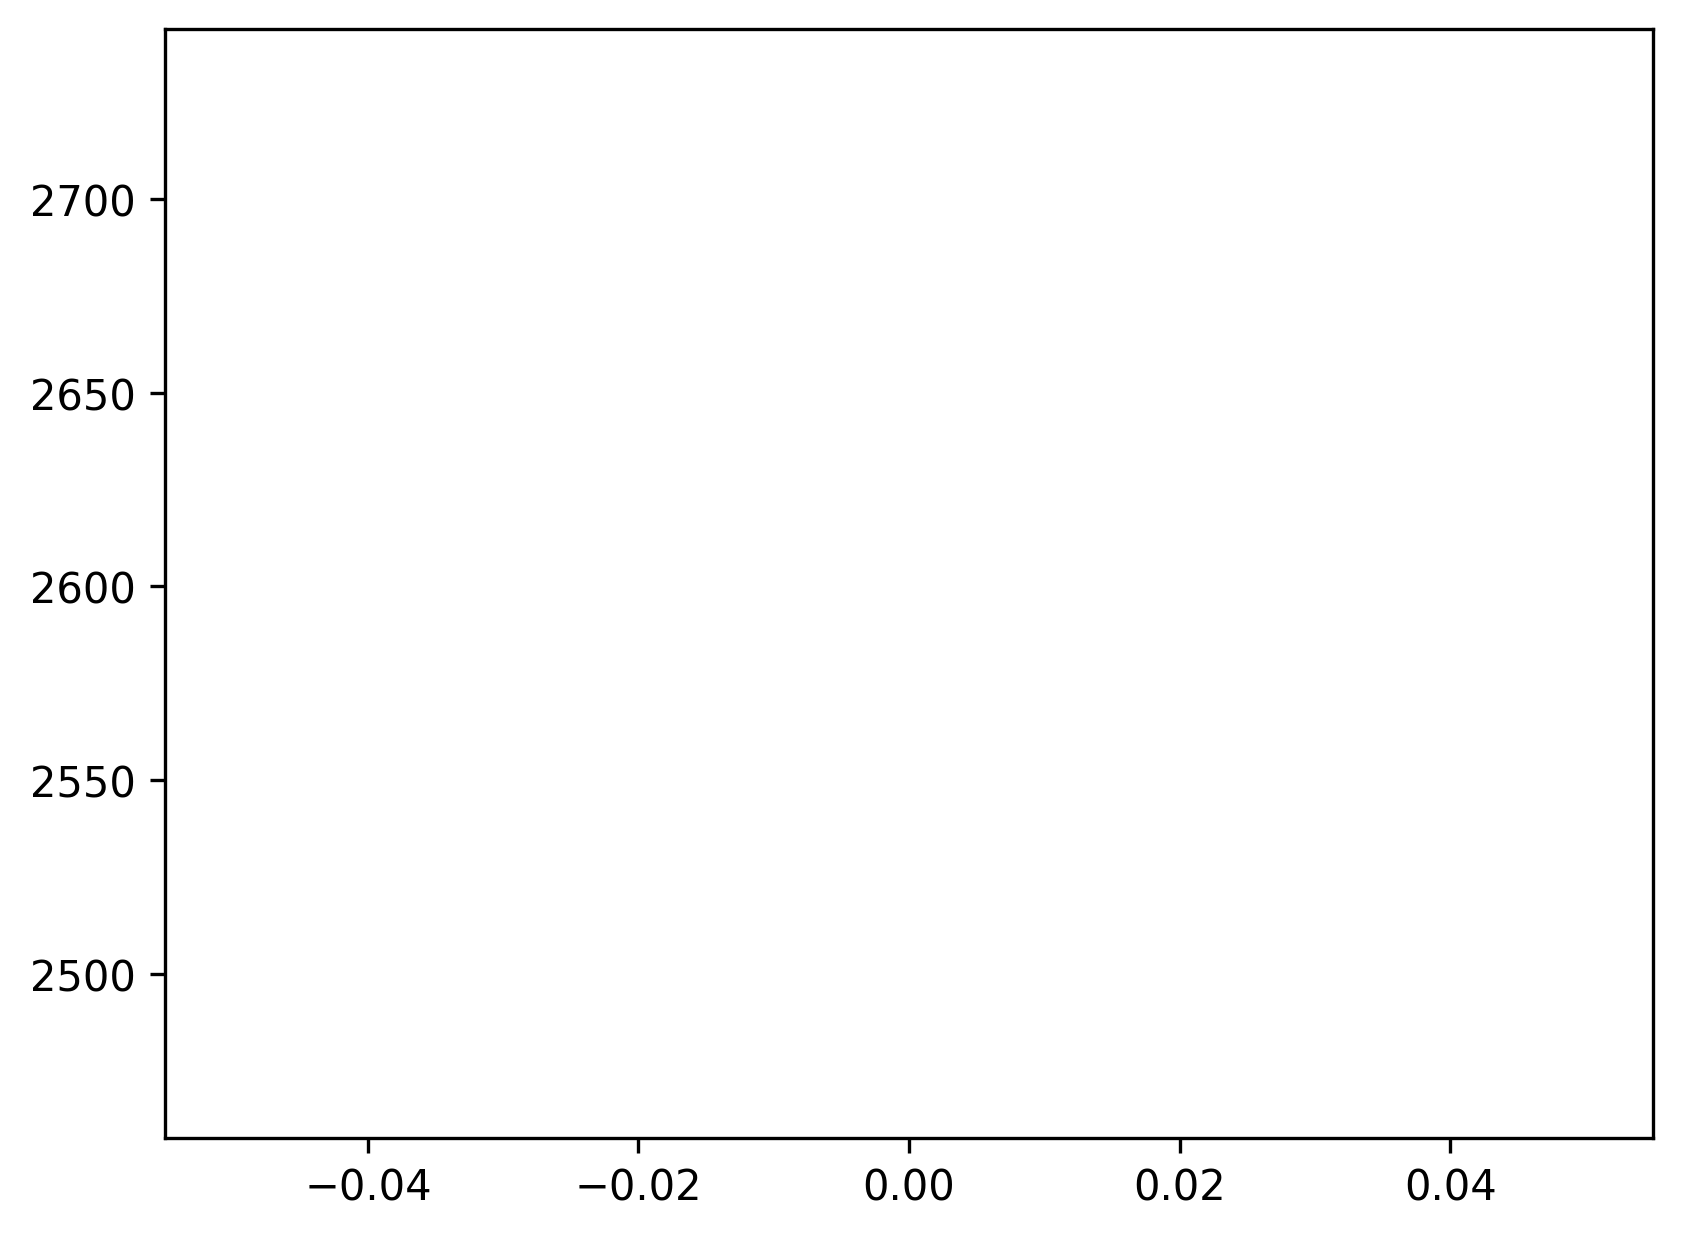

In [14]:
params = model.get_params(model.opt_state)
# Save the trained model
flat_params, _  = ravel_pytree(model.get_params(model.opt_state))

# jnp.save(opt.datafolder+'adv_params.npy', flat_params)
# jnp.save(opt.datafolder+'adv_loss.npy', model.loss_log)

# #Restore the trained model
# flat_paaarams = jnp.load('adv_params.npy')
# params = model.unravel_params(flat_params)
# loss_log = np.load('adv_loss.npy')

fig = plt.figure()
plt.plot(model.loss_log)


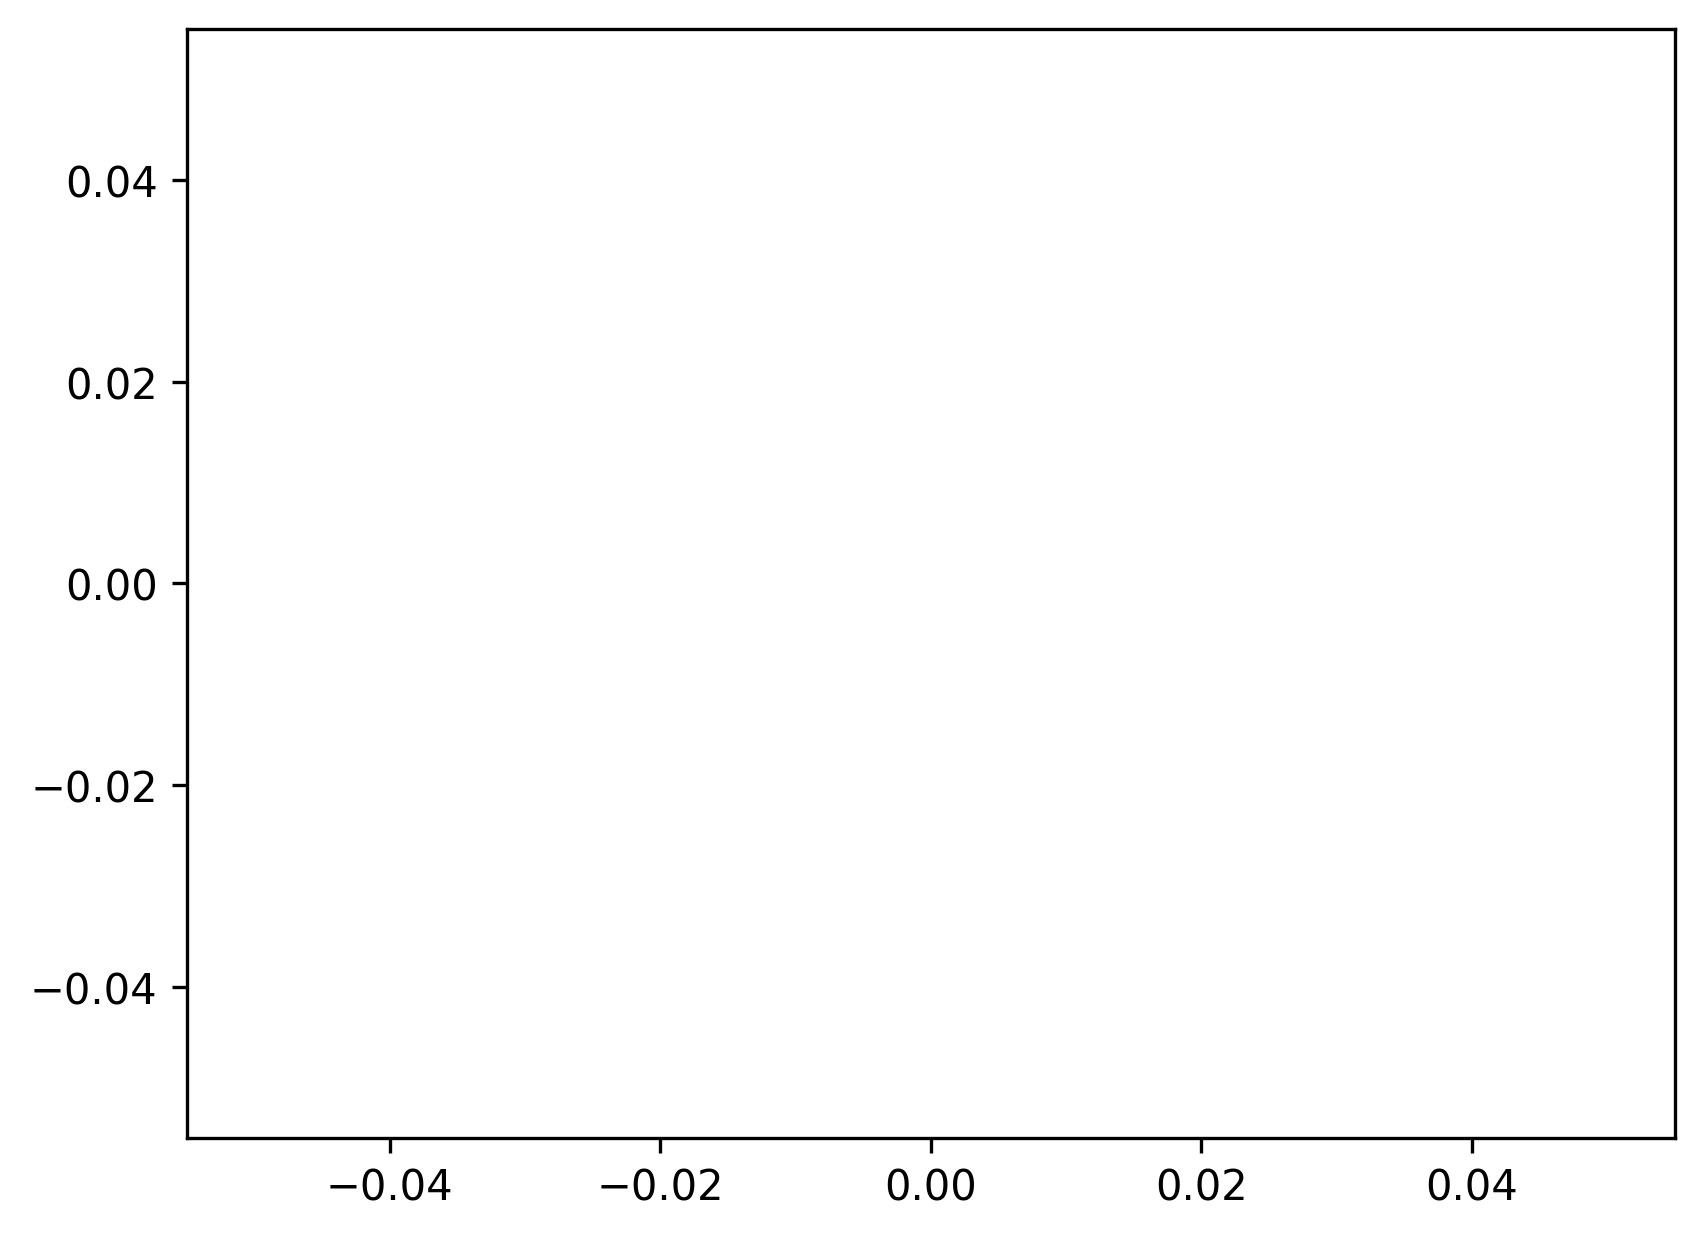

In [15]:
# print(model.loss_log)
plt.plot(model.loss_log[1:])

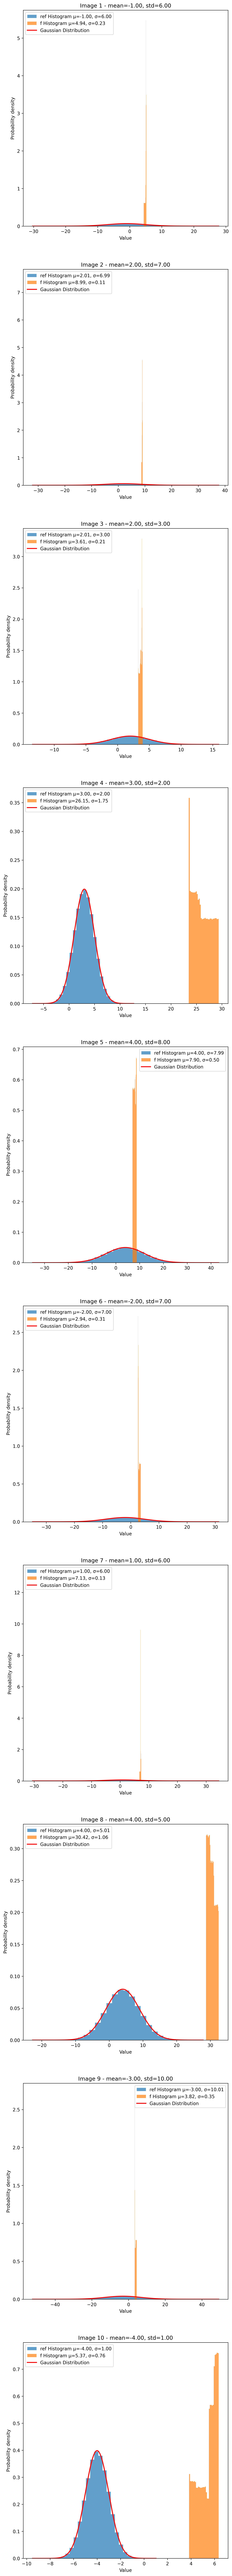

In [16]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.stats import norm

# print(opt.eta_list)
xpre,_=PredictDataGenerator(opt,dataset,rng_key=key_g,is_train_data=True)
# print(xpre.shape)
params = model.get_params(model.opt_state)
f=jax.device_get(model.predict(params,xpre))
ref=dataset.data_set[:,:,0:opt.dim]

# opt.n_dict = 4
# 绘制前两张图
fig, axes = plt.subplots(opt.n_dict, 1, figsize=(8, 10*opt.n_dict))

mean, std = xpre[:,0,opt.dim:].T
# print(x.shape)

for i in range(opt.n_dict):#[params0]
    data=ref[i,:,:]
    data_f=f[i,:,:]

    # 获取第j张图的数据,随机
    # j = opt.index_list[i]
    # data = all_data[j, :]
    
    mean,std = opt.eta_list[i]
    # std = opt.eta_list[i]
    # print(mean,means[j])
    # print(std,stds[j])
    
    # 生成高斯分布曲线的x轴
    x = np.linspace(data.min(), data.max(), 100)
    
    # 计算数据的均值和标准差
    mean_sample = np.mean(data)
    std_sample = np.std(data)

    mean_f = np.mean(data_f)
    std_f = np.std(data_f)
    
    # 绘制直方图
    axes[i].hist(data, bins=30, density=True, alpha=0.7, label=f'ref Histogram μ={mean_sample:.2f}, σ={std_sample:.2f}')
    axes[i].hist(data_f, bins=30, density=True, alpha=0.7, label=f'f Histogram μ={mean_f:.2f}, σ={std_f:.2f}')
    
    # 绘制高斯分布曲线
    axes[i].plot(x, norm.pdf(x, mean, std), 'r-', lw=2, label='Gaussian Distribution')
    
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Probability density')
    # axes[i].set_title(f'Image {i+1}')
    axes[i].set_title(f'Image {i+1} - mean={mean:.2f}, std={std:.2f}')
    
    axes[i].legend()
    axes[i].grid(False)

plt.show()

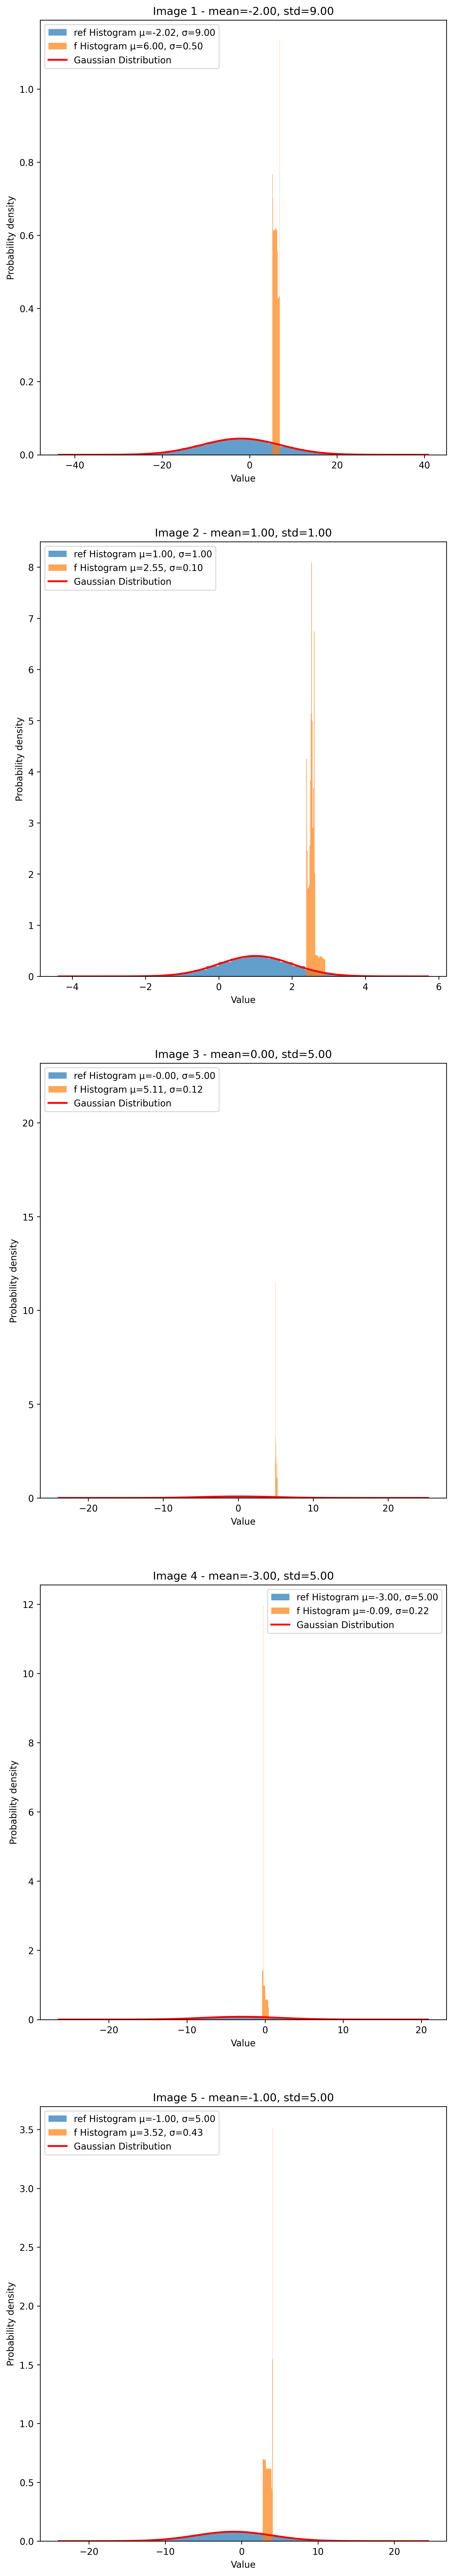

In [17]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.stats import norm

opt.eta_list = []
opt.n_dict = 5
xpre,ref=PredictDataGenerator(opt,dataset,rng_key=key_g,is_train_data=False)
params = model.get_params(model.opt_state)
f=jax.device_get(model.predict(params,xpre))
# ref=dataset.data_set[:,:,0:opt.dim]

# 绘制前两张图
fig, axes = plt.subplots(opt.n_dict, 1, figsize=(8, 10*opt.n_dict))

mean, std = xpre[:,0,opt.dim:].T
# print(x.shape)

for i in range(opt.n_dict):#[params0]
    data=ref[i,:,:]
    data_f=f[i,:,:]

    # 获取第j张图的数据,随机
    # j = opt.index_list[i]
    # data = all_data[j, :]
    
    mean,std = opt.eta_list[i]
    # std = opt.eta_list[i]
    # print(mean,means[j])
    # print(std,stds[j])
    
    # 生成高斯分布曲线的x轴
    x = np.linspace(data.min(), data.max(), 100)
    
    # 计算数据的均值和标准差
    mean_sample = np.mean(data)
    std_sample = np.std(data)

    mean_f = np.mean(data_f)
    std_f = np.std(data_f)
    
    # 绘制直方图
    axes[i].hist(data, bins=30, density=True, alpha=0.7, label=f'ref Histogram μ={mean_sample:.2f}, σ={std_sample:.2f}')
    axes[i].hist(data_f, bins=30, density=True, alpha=0.7, label=f'f Histogram μ={mean_f:.2f}, σ={std_f:.2f}')
    
    # 绘制高斯分布曲线
    axes[i].plot(x, norm.pdf(x, mean, std), 'r-', lw=2, label='Gaussian Distribution')
    
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Probability density')
    # axes[i].set_title(f'Image {i+1}')
    axes[i].set_title(f'Image {i+1} - mean={mean:.2f}, std={std:.2f}')
    
    axes[i].legend()
    axes[i].grid(False)

plt.show()